In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os import makedirs
from os.path import join, exists
from nilearn.plotting import plot_connectome, plot_roi, find_parcellation_cut_coords
import bct
import datetime
from nilearn.mass_univariate import permuted_ols
from scipy.stats import pearsonr, spearmanr

sns.set(context='poster', style='ticks')

In [2]:

def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [3]:
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']
#subjects = ['101', '102']
kappa_upper = 0.21
kappa_lower = 0.31

sink_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/data/output'
fig_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/figures/'

shen = '/Users/katherine/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
craddock = '/Users/katherine/Dropbox/Projects/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'
masks = ['shen2015', 'craddock2012']

tasks = {'reas': [{'conditions': ['Reasoning', 'Baseline']},
                  {'runs': [0,1]}],
         'retr': [{'conditions': ['Physics', 'General']},
                  {'runs': [0,1]}], 
         'fci': [{'conditions': ['Physics', 'NonPhysics']},
                  {'runs': [0,1,2]}]}

sessions = [0,1]
sesh = ['pre', 'post']
conds = ['high-level', 'lower-level']

index = pd.MultiIndex.from_product([subjects, sessions, tasks, conds, masks], 
                                   names=['subject', 'session', 'task', 'condition', 'mask'])

In [4]:
shen_df = pd.read_csv(join(sink_dir, 'task-shen-triplenetwork.csv'), index_col=0, header=0)
shen_df.rename({'Unnamed: 1': 'session', 'Unnamed: 2': 'task', 'Unnamed: 3': 'condition'}, axis=1, inplace=True)
shen_rest_df = pd.read_csv(join(sink_dir, 'rest-shen-triplenetwork.csv'), index_col=0, header=0)
shen_rest_df.rename({'Unnamed: 1': 'session'}, axis=1, inplace=True)

In [5]:
shen_df.head()

,session,task,condition,5dmn-138dmn,5dmn-140dmn,5dmn-145dmn,5dmn-174dmn,5dmn-176dmn,5dmn-178dmn,5dmn-182dmn,...,221sal-200cen,221sal-201cen,221sal-163sal,221sal-261sal,221sal-169sal,221sal-188sal,221sal-152sal,221sal-153sal,221sal-124sal,221sal-125sal
101,0,reas,high-level,0.350339,0.432467,0.437446,0.273700,0.000000,0.000000,0.0,...,0.258145,0.000000,0.307887,0.000000,0.342796,0.268944,0.143167,0.000000,0.138018,0.126368
101,0,reas,lower-level,0.000000,0.309238,0.288660,0.409792,0.422957,0.127056,0.0,...,0.207569,0.232726,0.369970,0.454479,0.383915,0.330818,0.404091,0.256938,0.377177,0.391398
101,0,retr,high-level,0.552308,0.699323,0.684909,0.724236,0.424468,0.000000,0.0,...,0.269743,0.000000,0.000000,0.717219,0.000000,0.578039,0.000000,0.290816,0.440442,0.386387
101,0,retr,lower-level,0.446967,0.651628,0.656367,0.755367,0.532567,0.000000,0.0,...,0.512291,0.496197,0.541293,0.674339,0.487869,0.726764,0.505632,0.554935,0.600793,0.586221
101,0,fci,high-level,0.482300,0.473631,0.410594,0.549831,0.197527,0.000000,0.0,...,0.277785,0.208784,0.000000,0.161700,0.281067,0.311762,0.151130,0.163395,0.150721,0.388858


In [11]:
rest_pre = shen_rest_df[shen_rest_df['session'] == 0].dropna()
rest_post = shen_rest_df[shen_rest_df['session'] == 1].dropna()

In [12]:
data_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/data'
b_df = pd.read_csv(join(data_dir, 'rescored', 'non-brain-data.csv'), index_col=0, header=0)

df_f = b_df[b_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = b_df[b_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

df_f['const'] = 1
df_m['const'] = 1

In [13]:
head_size = pd.read_csv(join(data_dir, 'head-size_2019-05-29 15:19:53.287525.csv'), index_col=0, header=0)
head_size['normalized head size'] = (head_size['average_head_size']-np.mean(head_size['average_head_size']))/np.std(head_size['average_head_size'])

In [14]:
rest_fd = pd.read_csv(join(data_dir, 'avg-fd-per-run-rest_2019-05-31.csv'), index_col=0, header=0)
rest_fd['normalized fd'] = (rest_fd['average fd']-np.mean(rest_fd['average fd']))/np.std(rest_fd['average fd'])

In [15]:
df_pivot = rest_fd.reset_index()
rest_fd = df_pivot.pivot(index='subject', columns='session', values='normalized fd')
rest_fd.rename({'pre': 'pre rest fd', 'post': 'post rest fd'}, axis=1, inplace=True)

In [16]:
fd = pd.read_csv(join(data_dir,'avg-fd-per-condition-per-run_2019-05-29.csv'), index_col=0, header=0)
fd['normalized fd'] = (fd['average fd']-np.mean(fd['average fd']))/np.std(fd['average fd'])
retr_fd = fd[fd['task'] == 'retr']
reas_fd = fd[fd['task'] == 'reas']
fci_fd = fd[fd['task'] == 'fci']

df_pivot = retr_fd[retr_fd['condition'] == 'high-level'].reset_index()
retr_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_phys_fd.rename({'pre': 'pre phys retr fd', 'post': 'post phys retr fd'}, axis=1, inplace=True)

df_pivot = retr_fd[retr_fd['condition'] == 'lower-level'].reset_index()
retr_genr_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_genr_fd.rename({'pre': 'pre gen retr fd', 'post': 'post gen retr fd'}, axis=1, inplace=True)

df_pivot = reas_fd[reas_fd['condition'] == 'high-level'].reset_index()
reas_inf_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
reas_inf_fd.rename({'pre': 'pre infr reas fd', 'post': 'post infr reas fd'}, axis=1, inplace=True)

df_pivot = reas_fd[reas_fd['condition'] == 'lower-level'].reset_index()
reas_base_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
reas_base_fd.rename({'pre': 'pre base reas fd', 'post': 'post base reas fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'high-level'].reset_index()
fci_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_phys_fd.rename({'pre': 'pre phys fci fd', 'post': 'post phys fci fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'lower-level'].reset_index()
fci_ctrl_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_ctrl_fd.rename({'pre': 'pre ctrl fci fd', 'post': 'post ctrl fci fd'}, axis=1, inplace=True)

In [17]:
iqs = ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']

In [18]:
big_df = pd.concat([b_df, retr_phys_fd, retr_genr_fd, fci_phys_fd, fci_ctrl_fd, 
                    reas_base_fd, reas_inf_fd, rest_fd], axis=1)

In [19]:
fci_shen = shen_df[shen_df['task'] == 'fci']
fci_shen_pre = fci_shen[fci_shen['session'] == 0]
fci_shen_pre_phys = fci_shen_pre[fci_shen_pre['condition'] == 'high-level']
fci_shen_pre_ctrl = fci_shen_pre[fci_shen_pre['condition'] == 'lower-level']
fci_shen_post = fci_shen[fci_shen['session'] == 1]
fci_shen_post_phys = fci_shen_post[fci_shen_post['condition'] == 'high-level']
fci_shen_post_ctrl = fci_shen_post[fci_shen_post['condition'] == 'lower-level']

In [20]:
retr_shen = shen_df[shen_df['task'] == 'retr']
retr_shen_pre = retr_shen[retr_shen['session'] == 0]
retr_shen_pre_phys = retr_shen_pre[retr_shen_pre['condition'] == 'high-level']
retr_shen_pre_ctrl = retr_shen_pre[retr_shen_pre['condition'] == 'lower-level']
retr_shen_post = retr_shen[retr_shen['session'] == 1]
retr_shen_post_phys = retr_shen_post[retr_shen_post['condition'] == 'high-level']
retr_shen_post_ctrl = retr_shen_post[retr_shen_post['condition'] == 'lower-level']

In [21]:
reas_shen = shen_df[shen_df['task'] == 'reas']
reas_shen_pre = reas_shen[reas_shen['session'] == 0]
reas_shen_pre_infr = reas_shen_pre[reas_shen_pre['condition'] == 'high-level']
reas_shen_pre_ctrl = reas_shen_pre[reas_shen_pre['condition'] == 'lower-level']
reas_shen_post = reas_shen[reas_shen['session'] == 1]
reas_shen_post_infr = reas_shen_post[reas_shen_post['condition'] == 'high-level']
reas_shen_post_ctrl = reas_shen_post[reas_shen_post['condition'] == 'lower-level']

In [22]:
fci_shen_pre_phys.drop(['session', 'task', 'condition'], axis=1, inplace=True)
fci_shen_post_phys.drop(['session', 'task', 'condition'], axis=1, inplace=True)

fci_shen_pre_ctrl.drop(['session', 'task', 'condition'], axis=1, inplace=True)
fci_shen_post_ctrl.drop(['session', 'task', 'condition'], axis=1, inplace=True)

retr_shen_pre_phys.drop(['session', 'task', 'condition'], axis=1, inplace=True)
retr_shen_post_phys.drop(['session', 'task', 'condition'], axis=1, inplace=True)

retr_shen_pre_ctrl.drop(['session', 'task', 'condition'], axis=1, inplace=True)
retr_shen_post_ctrl.drop(['session', 'task', 'condition'], axis=1, inplace=True)

reas_shen_pre_ctrl.drop(['session', 'task', 'condition'], axis=1, inplace=True)
reas_shen_pre_infr.drop(['session', 'task', 'condition'], axis=1, inplace=True)

rest_pre.drop(['session'], axis=1, inplace=True)
rest_post.drop(['session'], axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
#from all ppts with data, remove the female participants, then remove the participants with missing brain data
male_rest_index = list(set(rest_pre.index.values) - set(big_df[big_df['Sex'] == 'F'].index.values))
feml_rest_index = list(set(rest_pre.index.values) - set(big_df[big_df['Sex'] == 'M'].index.values))

In [24]:
f_rest_pre = rest_pre.drop(male_rest_index, axis=0)
m_rest_pre = rest_pre.drop(feml_rest_index, axis=0)

f_rest_post = rest_pre.drop(male_rest_index, axis=0)
m_rest_post = rest_pre.drop(feml_rest_index, axis=0)

In [25]:
m_rest_post.index.shape

(59,)

In [26]:
for column in rest_pre.columns:
    num = np.nonzero(f_rest_pre[column].values)[0].shape
    if num[0] <=  5:
        f_rest_pre.drop(column, axis=1, inplace=True)
    num = np.nonzero(m_rest_pre[column].values)[0].shape
    if num[0] <=  5:
        m_rest_pre.drop(column, axis=1, inplace=True)

In [27]:
for column in rest_post.columns:
    num = np.nonzero(f_rest_post[column].values)[0].shape
    if num[0] <= 5:
        f_rest_post.drop(column, axis=1, inplace=True)
    num = np.nonzero(m_rest_post[column].values)[0].shape
    if num[0] <= 5:
        m_rest_post.drop(column, axis=1, inplace=True)

In [28]:
conns = list(set(f_rest_pre.columns))

In [33]:
task = {'pre rest': rest_pre,
        'post rest': rest_post,
        'post phys fci': fci_shen_post_phys,
        'pre phys fci': fci_shen_pre_phys,
        'post phys retr': retr_shen_post_phys,
        'pre phys retr': retr_shen_pre_phys}

In [38]:
connectivity = task['pre rest'] 
all_data = pd.concat([big_df, connectivity], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(connectivity.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

all_data[conns].values[0]

array([0.17634718, 0.37851093, 0.49156721, ..., 0.28091738, 0.        ,
       0.        ])

In [40]:
iq = 'VCI'
key = 'pre rest'
p, t, _ = permuted_ols(all_data['{0}1'.format(iq)], 
                           all_data[conns], 
                           all_data[['{0}1XSex'.format(iq), '{0}1XClass'.format(iq), 
                                     '{0}1XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', '{0} fd'.format(key)]],
                           n_perm=500)

In [ ]:
for iq in iqs: 
    p, t, _ = permuted_ols(all_data['{0}1'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}1XSex'.format(iq), '{0}1XClass'.format(iq), 
                                     '{0}1XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', '{0} fd'.format(key)]].values,
                           n_perm=500)
    sig['pre (IQ): {0}, {1}'.format(iq, key)] = np.max(p[0])

In [197]:
sig = {}
nodaleff_sig = pd.DataFrame(index=conns)

for key in task.keys():
    connectivity = task[key]
    
    all_data = pd.concat([big_df, connectivity], axis=1)
    all_data.dropna(how='any', axis=0, inplace=True)
    conns = list(set(connectivity.columns))
    
    for column in all_data[conns]:
        if all_data[column].std() < 0.05:
            all_data.drop(column, axis=1, inplace=True)
            conns = list(set(conns) - set([column]))
    if key[0:4] == 'post':
        for iq in iqs: 
            p, t, _ = permuted_ols(all_data['{0}2'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}2XSex'.format(iq), '{0}2XClass'.format(iq), 
                                             '{0}2XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['post (IQ): {0}, {1}'.format(iq, key)] = np.max(p[0])
            #if np.max(p) > 1:
            #    nodaleff_sig['{0}2 {1} p'.format(iq, key)] = p.T
            #    nodaleff_sig['{0}2 {1} t'.format(iq, key)] = t.T

            p, t, _ = permuted_ols(all_data['{0}2XSex'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}2'.format(iq), '{0}2XClass'.format(iq), 
                                             '{0}2XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['post (IQXSex): {0}, {1}'.format(iq, key)] = np.max(p[0])

            p, t, _ = permuted_ols(all_data['{0}2XClass'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}2'.format(iq), '{0}2XSex'.format(iq), 
                                             '{0}2XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)

                
            sig['post (IQXClass): {0}, {1}'.format(iq, key)] = np.max(p[0])
            p, t, _ = permuted_ols(all_data['{0}2XClass'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}2'.format(iq), '{0}2XSex'.format(iq), 
                                             '{0}2XClass'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['post (IQXSexXClass): {0}, {1}'.format(iq, key)] = np.max(p[0])

                
            p, t, _ = permuted_ols(all_data['delta{0}'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['delta{0}XSex'.format(iq), 'delta{0}XClass'.format(iq), 
                                             'delta{0}XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['delta (IQ): {0}, {1}'.format(iq, key)] = np.max(p[0])

                
            p, t, _ = permuted_ols(all_data['delta{0}XSex'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['delta{0}'.format(iq), 'delta{0}XClass'.format(iq), 
                                             'delta{0}XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['delta (IQXSex): {0}, {1}'.format(iq, key)] = np.max(p[0])

                
            p, t, _ = permuted_ols(all_data['delta{0}XClass'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['delta{0}'.format(iq), 'delta{0}XSex'.format(iq), 
                                             'delta{0}XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['delta (IQXClass): {0}, {1}'.format(iq, key)] = np.max(p[0])

            
            p, t, _ = permuted_ols(all_data['delta{0}XClass'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['delta{0}'.format(iq), 'delta{0}XSex'.format(iq), 
                                             'delta{0}XClass'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['delta (IQXSexXClass): {0}, {1}'.format(iq, key)] = np.max(p[0])

            
    else:
        for iq in iqs: 
            p, t, _ = permuted_ols(all_data['{0}1'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}1XSex'.format(iq), '{0}1XClass'.format(iq), 
                                             '{0}1XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['pre (IQ): {0}, {1}'.format(iq, key)] = np.max(p[0])

                
            p, t, _ = permuted_ols(all_data['{0}1XSex'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}1'.format(iq), '{0}1XClass'.format(iq), 
                                             '{0}1XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['pre (IQXSex): {0}, {1}'.format(iq, key)] = np.max(p[0])

                
            p, t, _ = permuted_ols(all_data['{0}1XClass'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}1'.format(iq), '{0}1XSex'.format(iq), 
                                             '{0}1XClassXSex'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['pre (IQXClass): {0}, {1}'.format(iq, key)] = np.max(p[0])

                
            p, t, _ = permuted_ols(all_data['{0}1XClass'.format(iq)].values, 
                                   all_data[conns].values, 
                                   all_data[['{0}1'.format(iq), '{0}1XSex'.format(iq), 
                                             '{0}1XClass'.format(iq),
                                             'F', 'Strt.Level', 'SexXClass', 
                                             'Age', 'Mod', '{0} fd'.format(key)]].values,
                                   n_perm=50000)
            sig['pre (IQXSexXClass): {0}, {1}'.format(iq, key)] = np.max(p[0])


In [198]:
sessions = ['pre', 'post', 'delta']
variables = ['IQ', 'IQXSex', 'IQXClass', 'IQXClassXSex']
index = pd.MultiIndex.from_product([sessions, iqs, variables])
significant = pd.DataFrame(index=index)
for key in sig.keys():
    if sig[key] >= 1:
        #print(key, sig[key])
        sig_keys = key.split(',')
        sesh = sig_keys[1].split(' ')[1]
        task = sig_keys[1].split(' ')[-1]
        iq = sig_keys[0].split(' ')[-1]
        variable = sig_keys[0].split(' ')[1].strip('():')
        significant.at[(sesh, iq, variable), task] = sig[key]

In [199]:
significant.dropna(how='all')

rest       fci
pre  VCI  IQ        1.022285       NaN
          IQXSex    2.089384       NaN
     WMI  IQXSex         NaN  1.246272
post VCI  IQXSex    1.367551       NaN
     WMI  IQ             NaN  1.213683
          IQXSex         NaN  2.049644
          IQXClass       NaN  1.128319
     PRI  IQ             NaN  1.023109
     PSI  IQXSex         NaN  1.581376
     FSIQ IQ             NaN  1.172381
          IQXSex         NaN  1.487058

In [62]:
all_data = pd.concat([big_df, rest_pre], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(rest_pre.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

p, t, _ = permuted_ols(all_data['VCI1'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['VCI1XClass'.format(iq), 'VCI1XSex'.format(iq),
                                 'VCI1XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'pre rest fd'.format(key)]].values,
                       n_perm=50000)
pre_rest_sig = pd.DataFrame(index=conns)
if np.max(p) > 1:
    pre_rest_sig['VCI1 pre rest p'] = p.T
    pre_rest_sig['VCI1 pre rest t'] = t.T
    
p, t, _ = permuted_ols(all_data['VCI1XSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['VCI1XClass'.format(iq), 'VCI1'.format(iq),
                                 'VCI1XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'pre rest fd'.format(key)]].values,
                       n_perm=50000)

if np.max(p) > 1:
    pre_rest_sig['VCI1XSex pre rest p'] = p.T
    pre_rest_sig['VCI1XSex pre rest t'] = t.T

In [63]:
pre_rest_sig[pre_rest_sig['VCI1XSex pre rest p'] >= 1]

,VCI1 pre rest p,VCI1 pre rest t,VCI1XSex pre rest p,VCI1XSex pre rest t
188sal-227dmn,1.035843,-4.132897,2.113518,4.783441
227dmn-188sal,1.035843,-4.132897,2.113518,4.783441


In [64]:
coordinates = find_parcellation_cut_coords(labels_img='/Users/katherine/Dropbox/Data/templates/shen2015/shen_triplenetwork.nii.gz')

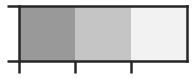

In [65]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])
grays = sns.light_palette('#999999', n_colors=3, reverse=True)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])
sns.palplot(grays)

Significant connections:
188sal 227dmn -4.13289691094572
227dmn 188sal -4.13289691094572


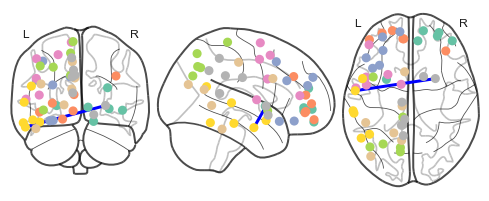

In [66]:
index = []
for column in pre_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_prevci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_prevci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_prevci_rest_p.at[region1,region2] = pre_rest_sig['VCI1 pre rest p']['{0}-{1}'.format(region1, region2)]
            sig_prevci_rest_t.at[region1,region2] = pre_rest_sig['VCI1 pre rest t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_prevci_rest_p.index:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_prevci_rest_p.columns:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_prevci_rest_p.sort_index(inplace=True)
sig_prevci_rest_p.sort_index(axis=1,inplace=True)
sig_prevci_rest_t.sort_index(inplace=True)
sig_prevci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_prevci_rest_p.index:
    for j in sig_prevci_rest_p.columns:
        if sig_prevci_rest_p.at[i,j] >= 1:
            print(i,j, sig_prevci_rest_t.at[i,j])
            thresh = int(sig_prevci_rest_t.at[i,j])
sig_prevci_rest_p.fillna(0, inplace=True)
sig_prevci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_prevci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_prevci_rest_p.to_csv(join(sink_dir, 'rest-vci1_conn_pvals.csv'.format(task, iq)))
sig_prevci_rest_t.to_csv(join(sink_dir, 'rest-vci1_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'f-rest-vci1_conn_sig.png').format(task, iq), dpi=300)

Significant connections:
188sal 227dmn 4.783440646778895
4
227dmn 188sal 4.783440646778895
4


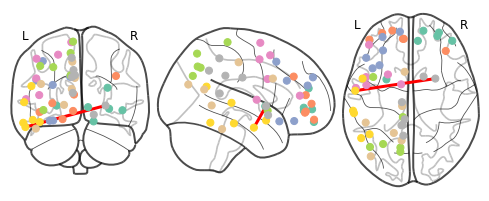

In [103]:
index = []
for column in pre_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_prevci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_prevci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_prevci_rest_p.at[region1,region2] = pre_rest_sig['VCI1XSex pre rest p']['{0}-{1}'.format(region1, region2)]
            sig_prevci_rest_t.at[region1,region2] = pre_rest_sig['VCI1XSex pre rest t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_prevci_rest_p.index:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_prevci_rest_p.columns:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_prevci_rest_p.sort_index(inplace=True)
sig_prevci_rest_p.sort_index(axis=1,inplace=True)
sig_prevci_rest_t.sort_index(inplace=True)
sig_prevci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_prevci_rest_p.index:
    for j in sig_prevci_rest_p.columns:
        if sig_prevci_rest_p.at[i,j] >= 1:
            print(i,j, sig_prevci_rest_t.at[i,j])
            thresh = int(sig_prevci_rest_t.at[i,j])
sig_prevci_rest_p.fillna(0, inplace=True)
sig_prevci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_prevci_rest_t.values, coordinates, edge_threshold=thresh)
sig_prevci_rest_p.to_csv(join(sink_dir, 'rest-vci1Xsex_conn_pvals.csv'.format(task, iq)))
sig_prevci_rest_t.to_csv(join(sink_dir, 'rest-vci1Xsex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'rest-vci1Xsex_conn_sig.png').format(task, iq), dpi=300)

In [70]:
from nilearn.input_data import NiftiLabelsMasker
test = NiftiLabelsMasker('/Users/katherine/Dropbox/Data/templates/shen2015/shen_triplenetwork.nii.gz')
data = test.fit_transform('/Users/katherine/Dropbox/Data/habenula/output/4d-cope.nii.gz')
data.shape


(28, 49)

In [75]:
data[0].shape

(49,)

In [71]:
p, t, _ = permuted_ols(np.random.random_sample(28), data)

In [73]:
p.shape

(1, 49)

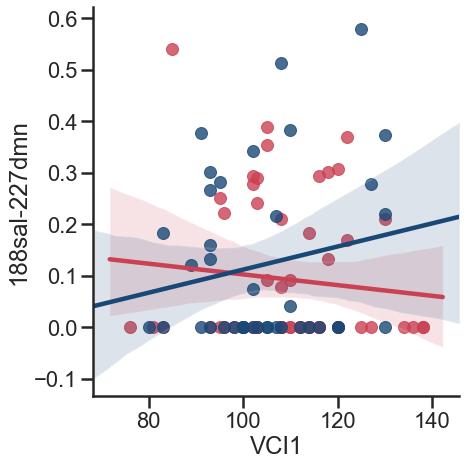

In [203]:
#fig,ax = plt.subplots()
all_data = pd.concat([big_df, rest_pre], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
k = sns.lmplot('VCI1', '188sal-227dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'rest-188sal-227dmn_VCI1XSex.png'.format(i, column)), dpi=300)

Significant connections:
174dmn 205dmn -4.510416165235839
205dmn 174dmn -4.510416165235839


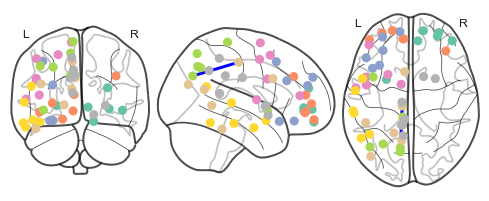

In [204]:
all_data = pd.concat([big_df, rest_post], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(rest_pre.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['deltaVCIXSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['deltaVCIXClass'.format(iq), 'deltaVCI'.format(iq),
                                 'deltaVCIXClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'pre rest fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) > 1:
    post_rest_sig['deltaVCIXSex pre rest p'] = p.T
    post_rest_sig['deltaVCIXSex pre rest t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_prevci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_prevci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_prevci_rest_p.at[region1,region2] = post_rest_sig['deltaVCIXSex pre rest p']['{0}-{1}'.format(region1, region2)]
            sig_prevci_rest_t.at[region1,region2] = post_rest_sig['deltaVCIXSex pre rest t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_prevci_rest_p.index:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_prevci_rest_p.columns:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_prevci_rest_p.sort_index(inplace=True)
sig_prevci_rest_p.sort_index(axis=1,inplace=True)
sig_prevci_rest_t.sort_index(inplace=True)
sig_prevci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_prevci_rest_p.index:
    for j in sig_prevci_rest_p.columns:
        if sig_prevci_rest_p.at[i,j] >= 1:
            print(i,j, sig_prevci_rest_t.at[i,j])
            thresh = int(sig_prevci_rest_t.at[i,j])
sig_prevci_rest_p.fillna(0, inplace=True)
sig_prevci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_prevci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_prevci_rest_p.to_csv(join(sink_dir, 'rest-deltaVCIXSex_conn_pvals.csv'.format(task, iq)))
sig_prevci_rest_t.to_csv(join(sink_dir, 'rest-deltaVCIXSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'f-rest-deltaVCIXSex_conn_sig.png').format(task, iq), dpi=300)

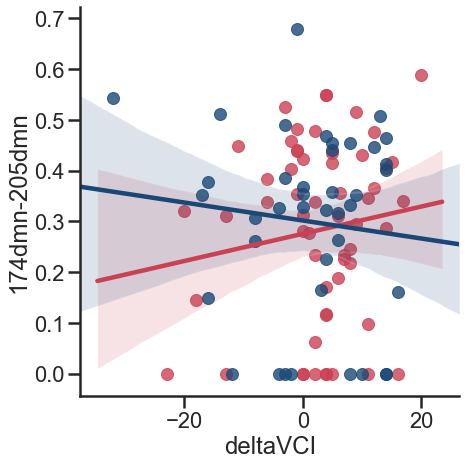

In [205]:
#fig,ax = plt.subplots()
all_data = pd.concat([big_df, rest_post], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
k = sns.lmplot('deltaVCI', '174dmn-205dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'rest-174dmn-205dmn_deltaVCIXSex.png'.format(i, column)), dpi=300)

In [206]:
significant.dropna(how='all')

rest       fci
pre  VCI  IQ        1.022285       NaN
          IQXSex    2.089384       NaN
     WMI  IQXSex         NaN  1.246272
post VCI  IQXSex    1.367551       NaN
     WMI  IQ             NaN  1.213683
          IQXSex         NaN  2.049644
          IQXClass       NaN  1.128319
     PRI  IQ             NaN  1.023109
     PSI  IQXSex         NaN  1.581376
     FSIQ IQ             NaN  1.172381
          IQXSex         NaN  1.487058

4.258665631512644
Significant connections:
011cen 177cen 4.258665631512644
177cen 011cen 4.258665631512644


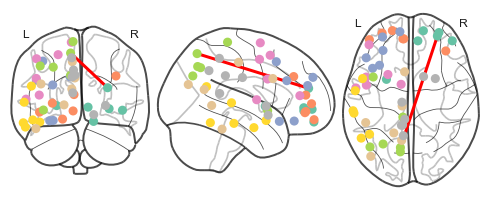

In [207]:
all_data = pd.concat([big_df, fci_shen_pre_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(fci_shen_pre_phys.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['WMI1XSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI1XClass'.format(iq), 'WMI1'.format(iq),
                                 'WMI1XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'pre phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI1XSex pre phys fci p'] = p.T
    post_rest_sig['WMI1XSex pre phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_prevci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_prevci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_prevci_rest_p.at[region1,region2] = post_rest_sig['WMI1XSex pre phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_prevci_rest_t.at[region1,region2] = post_rest_sig['WMI1XSex pre phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_prevci_rest_p.index:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_prevci_rest_p.columns:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_prevci_rest_p.sort_index(inplace=True)
sig_prevci_rest_p.sort_index(axis=1,inplace=True)
sig_prevci_rest_t.sort_index(inplace=True)
sig_prevci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_prevci_rest_p.index:
    for j in sig_prevci_rest_p.columns:
        if sig_prevci_rest_p.at[i,j] >= 1:
            print(i,j, sig_prevci_rest_t.at[i,j])
            thresh = int(sig_prevci_rest_t.at[i,j])
sig_prevci_rest_p.fillna(0, inplace=True)
sig_prevci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_prevci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_prevci_rest_p.to_csv(join(sink_dir, 'fci-WMI1XSex_conn_pvals.csv'.format(task, iq)))
sig_prevci_rest_t.to_csv(join(sink_dir, 'fci-WMI1XSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI1XSex_conn_sig.png').format(task, iq), dpi=300)

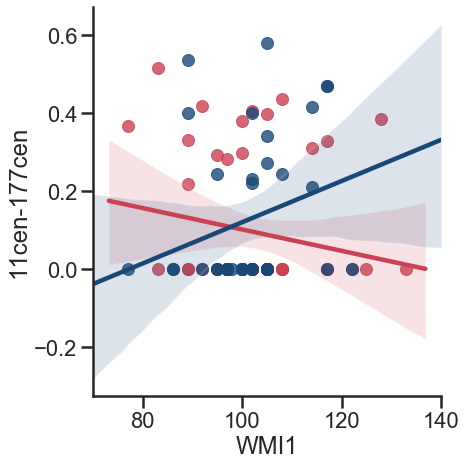

In [208]:
all_data = pd.concat([big_df, fci_shen_pre_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('WMI1', '11cen-177cen', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-11cen-177cen_WMI1XSex.png'.format(i, column)), dpi=300)

4.198453366916679
Significant connections:
138dmn 200cen 4.198453366916679
200cen 138dmn 4.198453366916679


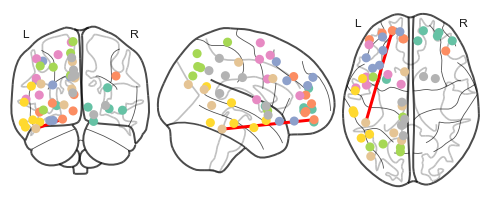

In [161]:
all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(fci_shen_post_phys.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['WMI2'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI2XClass'.format(iq), 'WMI2XSex'.format(iq),
                                 'WMI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI2 post phys fci p'] = p.T
    post_rest_sig['WMI2 post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['WMI2 post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['WMI2 post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-WMI2_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-WMI2_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI2_conn_sig.png').format(task, iq), dpi=300)

4.764546610545469
Significant connections:
178dmn 223dmn 4.764546610545469
223dmn 178dmn 4.764546610545469


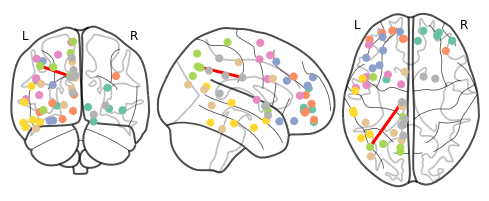

In [123]:
p, t, _ = permuted_ols(all_data['WMI2XSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI2XClass'.format(iq), 'WMI2'.format(iq),
                                 'WMI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI2XSex post phys fci p'] = p.T
    post_rest_sig['WMI2XSex post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['WMI2XSex post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['WMI2XSex post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-WMI2XSex_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-WMI2XSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI2XSex_conn_sig.png').format(task, iq), dpi=300)

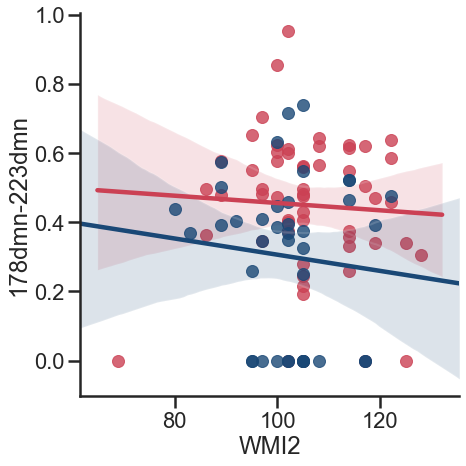

In [162]:
all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('WMI2', '178dmn-223dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-178dmn-223dmn_WMI2XSex.png'.format(i, column)), dpi=300)

3.955683810502702
Significant connections:
138dmn 200cen -4.151833728500401
200cen 138dmn -4.151833728500401


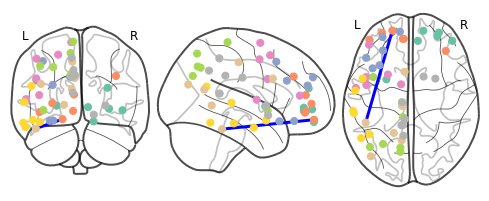

In [125]:
p, t, _ = permuted_ols(all_data['WMI2XClass'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI2XSex'.format(iq), 'WMI2'.format(iq),
                                 'WMI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI2XClass post phys fci p'] = p.T
    post_rest_sig['WMI2XClass post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['WMI2XClass post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['WMI2XClass post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-WMI2XClass_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-WMI2XClass_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI2XClass_conn_sig.png').format(task, iq), dpi=300)

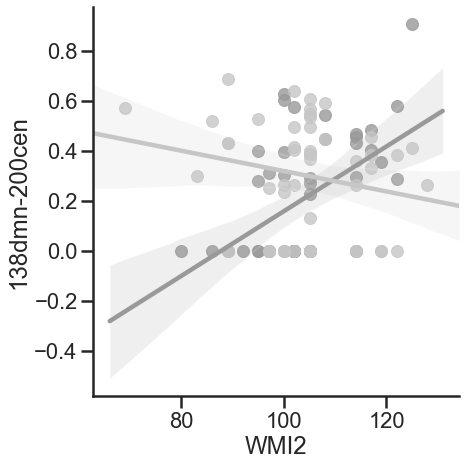

In [164]:
all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('WMI2', '138dmn-200cen', data=all_data, palette=grays, hue='Mod', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-178dmn-200cen_WMI2XClass.png'.format(i, column)), dpi=300)

2.174150404599952
Significant connections:
223dmn 224dmn -4.489151477069809
224dmn 223dmn -4.489151477069809


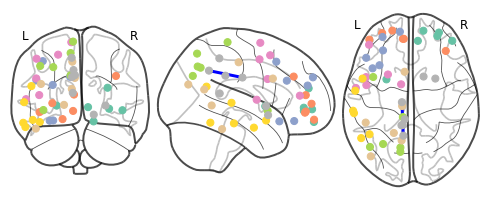

In [127]:
p, t, _ = permuted_ols(all_data['PSI2XSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['PSI2XClass'.format(iq), 'PSI2'.format(iq),
                                 'PSI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['PSI2XSex post phys fci p'] = p.T
    post_rest_sig['PSI2XSex post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['PSI2XSex post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['PSI2XSex post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-PSI2XSex_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-PSI2XSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-PSI2XSex_conn_sig.png').format(task, iq), dpi=300)

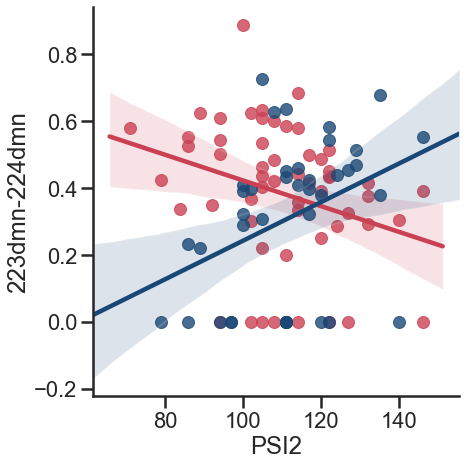

In [166]:
#all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
#all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('PSI2', '223dmn-224dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-223dmn-224dmn_PSI2XSex.png'.format(i, column)), dpi=300)

4.078345923525434
Significant connections:
143cen 226dmn 4.078345923525434
226dmn 143cen 4.078345923525434


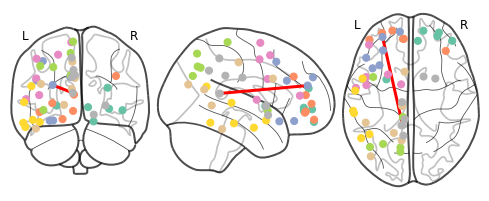

In [128]:
post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['PRI2'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['PRI2XClass'.format(iq), 'PRI2XSex'.format(iq),
                                 'PRI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['PRI2 post phys fci p'] = p.T
    post_rest_sig['PRI2 post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['PRI2 post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['PRI2 post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-PRI2_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-PRI2_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-PRI2_conn_sig.png').format(task, iq), dpi=300)

2.920868413221816
Significant connections:
147cen 224dmn -4.186040556978
224dmn 147cen -4.186040556978


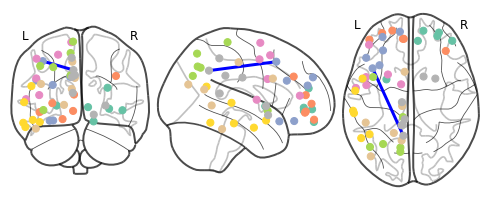

In [129]:
post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['deltaFSIQ'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['deltaFSIQXClass'.format(iq), 'deltaFSIQXSex'.format(iq),
                                 'deltaFSIQXClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['deltaFSIQ post phys fci p'] = p.T
    post_rest_sig['deltaFSIQ post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['deltaFSIQ post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['deltaFSIQ post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-deltaFSIQ_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-deltaFSIQ_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-deltaFSIQ_conn_sig.png').format(task, iq), dpi=300)

4.3911971858303716
Significant connections:
147cen 224dmn 4.3911971858303716
224dmn 147cen 4.3911971858303716


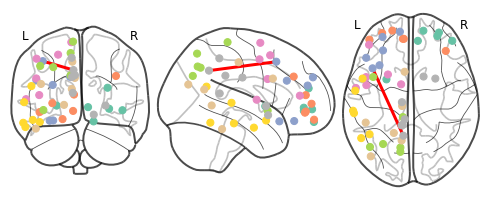

In [130]:
p, t, _ = permuted_ols(all_data['deltaFSIQXSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['deltaFSIQXClass'.format(iq), 'deltaFSIQ'.format(iq),
                                 'deltaFSIQXClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['deltaFSIQXSex post phys fci p'] = p.T
    post_rest_sig['deltaFSIQXSex post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['deltaFSIQXSex post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['deltaFSIQXSex post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-deltaFSIQXSex_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-deltaFSIQXSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-deltaFSIQXSex_conn_sig.png').format(task, iq), dpi=300)

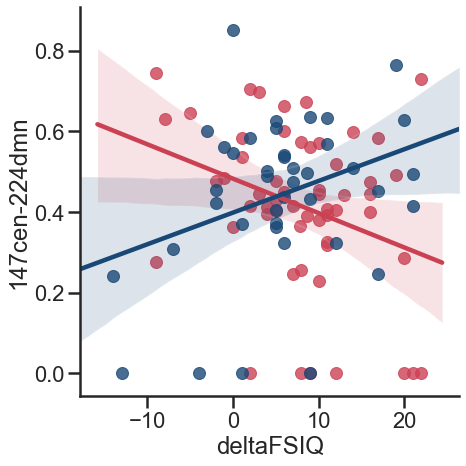

In [168]:
#all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
#all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('deltaFSIQ', '147cen-224dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-147cen-224dmn_deltaFSIQXSex.png'.format(i, column)), dpi=300)